In [32]:
import os
from nltk.tag import StanfordNERTagger as NERTagger
from nltk.tag import StanfordPOSTagger as POSTagger
ner_jar = 'StanfordNLP/jars/stanford-ner.jar'
ner_model = 'StanfordNLP/models/english.all.3class.distsim.crf.ser.gz'
pos_jar = 'StanfordNLP/jars/stanford-postagger.jar'
pos_model = 'StanfordNLP/models/english-bidirectional-distsim.tagger'
ner_tagger = NERTagger(ner_model, ner_jar)
pos_tagger = POSTagger(pos_model, pos_jar)

把預處理過的每家公司的10-K財報資料製造成一個按詞頻遞減的list，再把這些list放到一個list中

In [33]:
import pickle
dic_freq = []
companies = ['AAPL', 'GOOG', 'MSFT', 'CSCO', 'FB']
for comp in companies:
    with open('pickles/{}/{}_2017.pickle'.format(comp, comp), 'rb') as f:
        dic_freq.append(pickle.load(f))
word_list = []
for dic in dic_freq:
    word_list.append([i[0] for i in dic])
for wl in word_list:
    print(wl[:20])

['the', 'and', 'Company', 'The', 'for', 'any', 'that', 'with', 'are', 'its', 'may', 'other', 'Plan', 'Stock', 'such', 'not', 'shall', 'under', 'Participant', 'Award']
['and', 'the', 'our', 'for', 'are', 'that', 'from', 'revenues', 'other', 'Google', 'December', 'The', 'with', 'have', 'income', 'not', 'Alphabet', 'may', 'tax', 'net']
['and', 'the', 'our', 'for', 'revenue', 'are', 'that', 'with', 'billion', 'from', 'services', 'The', 'income', 'other', 'products', 'June', 'year', 'may', 'million', 'business']
['the', 'and', 'Company', 'any', 'for', 'Stock', 'that', 'with', 'Units', 'shall', 'our', 'you', 'are', 'this', 'The', 'your', 'may', 'other', 'Plan', 'Restricted']
['and', 'the', 'our', 'that', 'for', 'are', 'may', 'other', 'with', 'tax', 'from', 'products', 'not', 'have', 'financial', 'December', 'which', 'revenue', 'such', 'The']


用ner把這些詞分類至organization, location, person這三個類別

In [34]:
org_list = []
org_set = set()
loc_list = []
loc_set = set()
per_list = []
per_set = set()
for wl in word_list:
    dic_ner = dict(ner_tagger.tag(wl))
    org_list.append([])
    loc_list.append([])
    per_list.append([])
    for word, ner in dic_ner.items():
        if len(word) < 3:
            continue
        if ner == 'ORGANIZATION':
            org_list[-1].append(word)
            org_set.add(word)
        if ner == 'LOCATION':
            loc_list[-1].append(word)
            loc_set.add(word)
        if ner == 'PERSON':
            per_list[-1].append(word)
            per_set.add(word)
print(list(org_set)[:20])
print(list(loc_set)[:20])
print(list(per_set)[:20])

['Council', 'Morocco', 'Federal', 'Guatemala', 'Department', 'Analytics', 'Europe', 'Seznam', 'ParStream', 'BVBA', 'Long-Term', 'Argentina', 'unpatentable', 'Jones', 'PRE', 'Ireland', 'Qatar', 'Unified', 'Construction', 'Nacional']
['Taiwan', 'Arabia', 'Singapore', 'Europe', 'SUARL', 'Georgia', 'Denmark', 'Dakota', 'Pacific', 'Waiver', 'America', 'Ireland', 'Malaysia', 'Rico', 'Poland', 'Spain', 'Thailand', 'Road', 'Florida', 'Seattle']
['Field', 'Alan', 'Wagner', 'Frank', 'ROGER', 'Noski', 'Charles', 'Patel', 'Porat', 'Bradford', 'Barovic', 'ARIN', 'Sheryl', 'Christopher', 'Kondo', 'SCHARF', 'Ann', 'Capellas', 'CAMPBELL', 'SANDRA']


用pos把這些詞按照詞性分類，而我們只使用形容詞

In [50]:
adj_list = []
adj_set = set()
for wl in word_list:
    dic_pos = dict(pos_tagger.tag(wl[:200]))
    adj_list.append([])
    for word, pos in dic_pos.items():
        if len(word) < 3:
            continue
        if pos == 'JJ':
            adj_list[-1].append(word)
            adj_set.add(word)
print(list(adj_set)[:20])

['Other', 'third', 'control', 'significant', 'Tax-Related', 'affected', 'third-party', 'Total', 'common', 'pursuant', 'subject', 'Restricted', 'technical', 'additional', 'certain', 'registrant', 'Registrant', 'mobile', 'consolidated', 'Performance-Based']


organization類別的matrix

In [36]:
import numpy as np
import pandas as pd
org_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in org_set] for dic in dic_freq])
org_matrix = pd.DataFrame(org_matrix, columns = org_set, index = companies)
org_matrix

,Council,Morocco,Federal,Guatemala,Department,Analytics,Europe,Seznam,ParStream,BVBA,...,Estonia,Google,TOUCHE,Leasehold,Redmond,LLP,GAAP,Airespace,Holding,Title
AAPL,0,0,5,0,0,1,16,0,0,0,...,0,0,0,1,0,10,4,0,0,2
GOOG,1,0,3,0,5,0,9,1,0,0,...,0,245,0,1,0,10,6,0,1,3
MSFT,0,0,3,0,0,0,4,0,0,0,...,0,6,2,1,6,5,10,0,0,1
CSCO,0,2,15,2,2,2,11,0,1,1,...,2,0,0,1,0,3,1,1,1,4
FB,0,0,2,0,1,0,16,0,0,0,...,0,2,0,1,0,3,14,0,0,3


person類別的matrix

In [37]:
per_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in per_set] for dic in dic_freq])
per_matrix = pd.DataFrame(per_matrix, columns = per_set, index = companies)
per_matrix

,Field,Alan,Wagner,Frank,ROGER,Noski,Charles,Patel,Porat,Bradford,...,ROBERT,Mather,PETERSON,Stanton,RISTINA,SATYA,Teri,JOHN,Brod,Arthur
AAPL,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
GOOG,0,1,0,0,1,0,0,0,6,0,...,0,1,0,0,0,0,0,2,0,0
MSFT,0,0,0,3,0,1,2,0,0,1,...,0,0,1,1,0,1,1,2,3,0
CSCO,2,0,0,0,0,0,10,1,0,0,...,0,0,0,0,1,0,0,0,0,0
FB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


location類別的matrix

In [56]:
enm = list(enumerate(loc_set))
for i, word in enm:
    if i >= 50:
        loc_set.remove(word)
loc_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in loc_set] for dic in dic_freq])
loc_matrix = pd.DataFrame(loc_matrix, columns = loc_set, index = companies)
loc_matrix

,Taiwan,Arabia,Singapore,Europe,SUARL,Georgia,Denmark,Dakota,Pacific,Waiver,...,Tasman,Brasil,Africa,Silicon,Francisco,Atlantic,Iran,Alto,Asia-Pacific,Congo
AAPL,4,0,0,16,0,0,0,0,12,0,...,0,0,3,1,0,0,0,0,0,0
GOOG,0,0,0,9,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
MSFT,0,0,5,4,0,0,0,1,0,0,...,0,0,2,1,0,1,1,0,1,0
CSCO,4,4,7,11,1,2,9,0,4,9,...,2,4,11,2,0,0,0,1,0,0
FB,0,0,0,16,0,0,0,0,0,0,...,0,0,1,0,3,0,1,0,3,0


形容詞詞性類別的matrix，其中把大量出現但無意義的other和such先刪掉

In [51]:
unimportant = ['Other', 'other', 'such', 'such']
for word in unimportant:
    if word in adj_set:
        adj_set.remove(word)
#enm = list(enumerate(adj_set))
#for i, word in enm:
 #   if i >= 30:
  #      adj_set.remove(word)
adj_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in adj_set] for dic in dic_freq])
adj_df = pd.DataFrame(adj_matrix, columns = adj_set, index = companies)
adj_df

,third,control,significant,Tax-Related,affected,third-party,Total,common,pursuant,subject,...,regulatory,10-K,driven,cloud-based,otherwise,Financial,available,net,Ended,share-based
AAPL,28,48,54,24,33,53,70,55,85,171,...,1,126,5,0,61,61,57,203,1,11
GOOG,7,58,67,0,22,9,64,58,22,56,...,14,42,23,1,18,54,25,165,44,0
MSFT,12,29,71,0,15,14,65,29,7,38,...,16,38,56,34,5,47,37,86,38,0
CSCO,110,49,58,150,46,24,139,106,311,282,...,26,19,58,7,198,86,49,136,40,34
FB,35,51,69,0,37,12,48,135,16,71,...,32,40,8,0,26,49,26,95,30,42


形容詞詞性vs形容詞詞性的co-occurence matrix

In [52]:
adj_comatrix = np.matmul(np.transpose(adj_matrix), adj_matrix)
adj_comatrix = pd.DataFrame(adj_comatrix, columns = adj_set, index = adj_set)
adj_comatrix.to_csv('adj_comatrix.csv')
adj_comatrix

,third,control,significant,Tax-Related,affected,third-party,Total,common,pursuant,subject,...,regulatory,10-K,driven,cloud-based,otherwise,Financial,available,net,Ended,share-based
third,14302,9273,11628,17172,7613,4775,20158,18679,37388,39141,...,4298,7768,7633,1185,24584,13825,8515,26156,6242,5518
control,9273,11511,14898,8502,7436,5260,18216,18924,21614,29997,...,4230,12557,6448,1387,15145,14136,8986,33317,7192,4336
significant,11628,14898,20571,9996,9542,6679,24057,24378,25703,36939,...,5844,16178,9703,2887,18133,18618,12016,42566,10090,5464
Tax-Related,17172,8502,9996,23076,7692,4872,22530,17220,48690,46404,...,3924,5874,8820,1050,31164,14364,8718,25272,6024,5364
affected,7613,7436,9542,7692,5283,3705,12863,13397,18292,23044,...,2961,8006,4475,854,12554,9675,6202,21390,4521,3481
third-party,4775,5260,6679,4872,3705,3806,9108,8007,12457,17719,...,1411,8524,2744,653,8529,7029,5252,17852,2301,1903
Total,20158,18216,24057,22530,12863,9108,34846,30661,51810,60630,...,7156,18539,13908,3247,34517,25087,16054,53824,12356,7512
common,18679,18924,24378,17220,13397,8007,30661,36691,41280,53232,...,8407,17882,10461,1786,29042,23581,14362,50470,11999,9879
pursuant,37388,21614,25703,48690,18292,12457,51810,41280,104735,104871,...,9103,18449,19489,2437,67610,34232,21309,65303,14239,12181
subject,39141,29997,36939,46404,23044,17719,60630,53232,104871,118386,...,11167,33540,21195,3322,69311,42972,28217,92318,17489,14451


用gephi畫出的共現圖
![Alt text](adjective_coocurrence.png)

用seaborn套件畫出的熱點圖，為了提升視覺效果，使用的矩陣先標準化過了

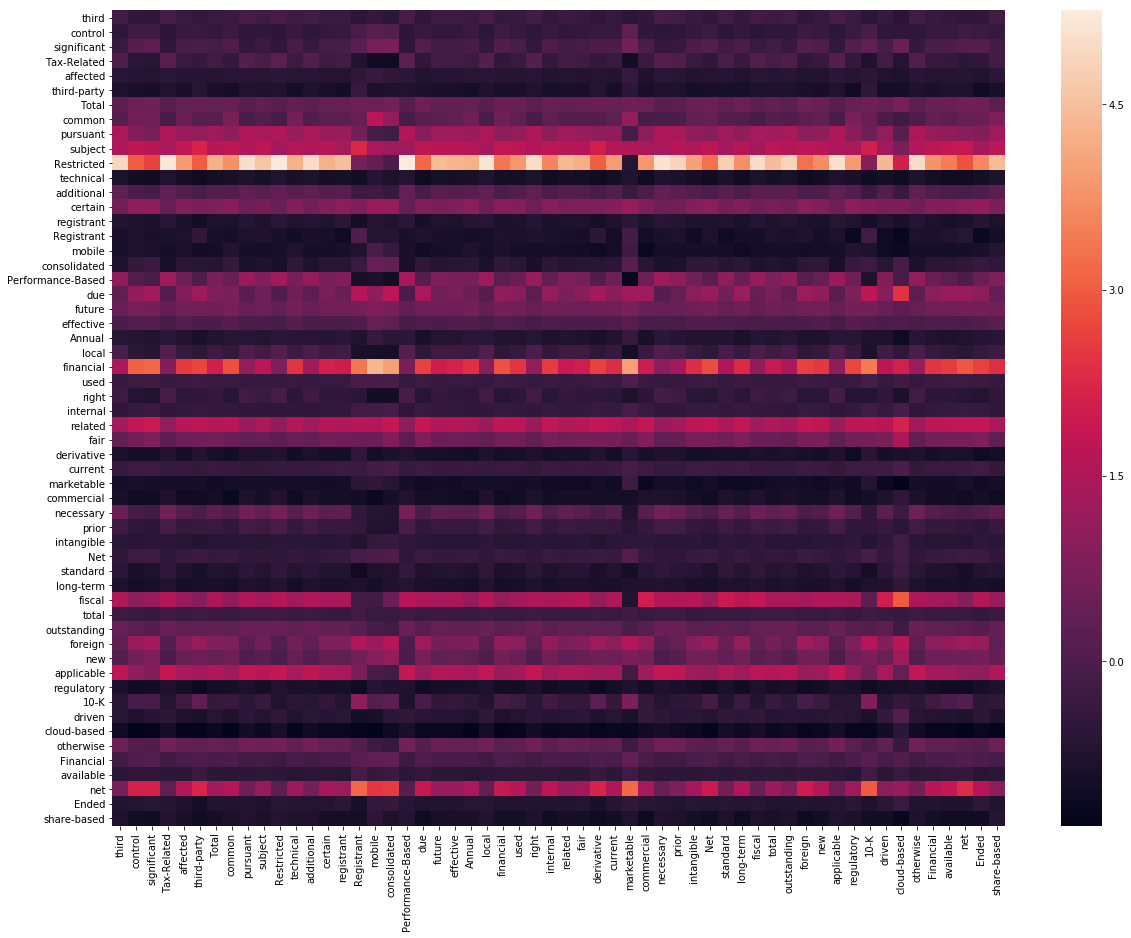

In [64]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,15))
adj_norm = (adj_comatrix - adj_comatrix.mean()) / adj_comatrix.std()
sn.heatmap(adj_norm)
plt.show()

location vs location的co-occurence matrix

In [58]:
loc_comatrix = np.matmul(np.transpose(loc_matrix), loc_matrix)
loc_comatrix = pd.DataFrame(loc_comatrix, columns = loc_set, index = loc_set)
loc_comatrix.to_csv('loc_comatrix.csv')
loc_comatrix

,Taiwan,Arabia,Singapore,Europe,SUARL,Georgia,Denmark,Dakota,Pacific,Waiver,...,Tasman,Brasil,Africa,Silicon,Francisco,Atlantic,Iran,Alto,Asia-Pacific,Congo
Taiwan,32,16,28,108,4,8,36,0,64,36,...,8,16,56,12,0,0,0,4,0,0
Arabia,16,16,28,44,4,8,36,0,16,36,...,8,16,44,8,0,0,0,4,0,0
Singapore,28,28,74,97,7,14,63,5,28,63,...,14,28,87,19,0,5,5,7,5,0
Europe,108,44,97,730,11,22,99,4,236,99,...,22,44,202,42,48,4,20,11,61,9
SUARL,4,4,7,11,1,2,9,0,4,9,...,2,4,11,2,0,0,0,1,0,0
Georgia,8,8,14,22,2,4,18,0,8,18,...,4,8,22,4,0,0,0,2,0,0
Denmark,36,36,63,99,9,18,81,0,36,81,...,18,36,99,18,0,0,0,9,0,0
Dakota,0,0,5,4,0,0,0,1,0,0,...,0,0,2,1,0,1,1,0,1,0
Pacific,64,16,28,236,4,8,36,0,160,36,...,8,16,80,20,0,0,0,4,0,0
Waiver,36,36,63,99,9,18,81,0,36,81,...,18,36,99,18,0,0,0,9,0,0


用gephi畫出的共現圖
![Alt text](location_coocurrence.png)

用seaborn套件畫出的熱點圖，為了提升視覺效果，使用的矩陣先標準化過了

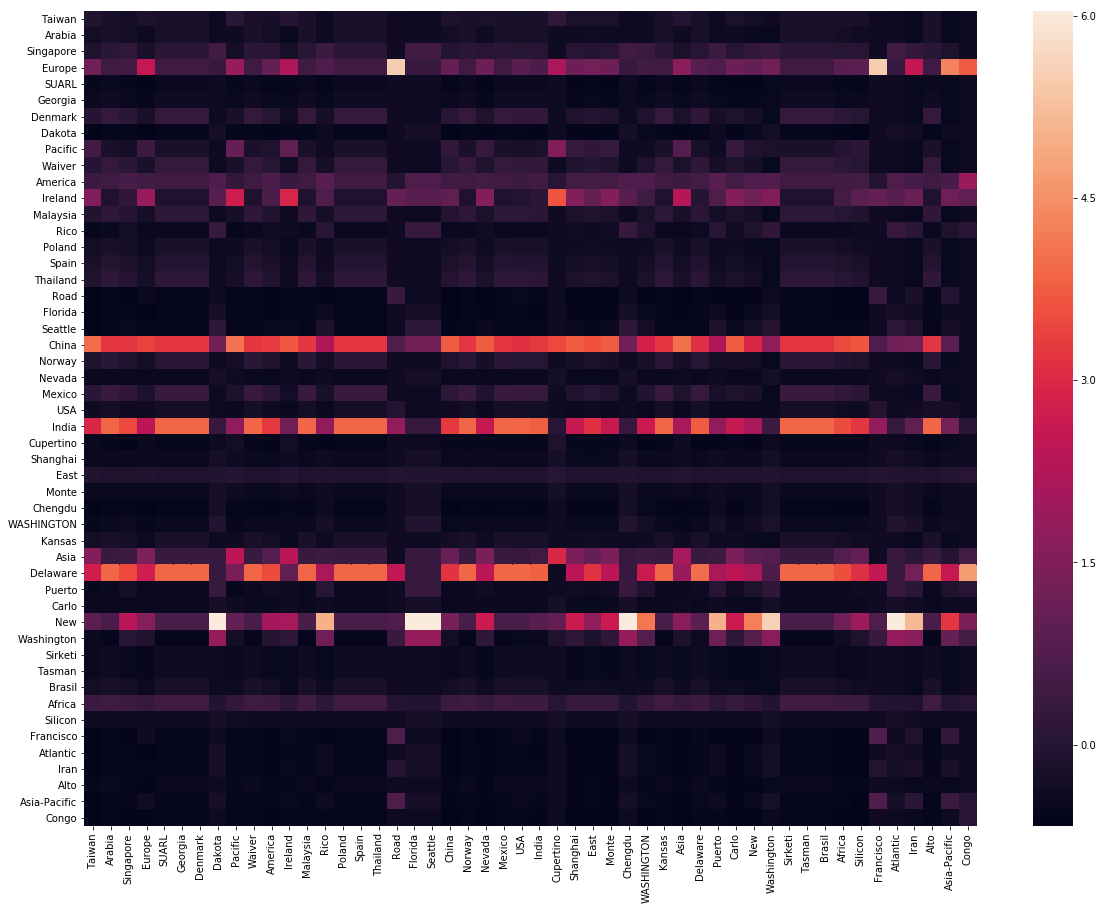

In [65]:
loc_norm = (loc_comatrix - loc_comatrix.mean()) / loc_comatrix.std()
plt.subplots(figsize=(20,15))
sn.heatmap(loc_norm)
plt.show()